In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))

import random
import os.path

import pycamhd.lazycache as lazycache     ## For accessing data through a Lazycache instance
import pycamhd.lazyqt as lazyqt           ## For accessing data on disk or through HTTP

import json

## Local imports
from timer import Timer


from dask import compute,delayed,threaded,multiprocessing

In [15]:
## Default values

## These paths must exist in all locations ... the code doesn't check...
ci_url_root = "https://rawdata.oceanobservatories.org/files/"

paths = ['/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T000000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T030000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T060000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T090000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T120000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T150000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T180000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T210000Z.mov'
        ]
local_path = "/data"

local_cached_url   = 'http://localhost:8080/'
local_uncached_url = 'http://localhost:9080/'

local_nginx_url    = 'http://localhost:9081/'

gae_uncached_url   = 'https://camhd-app-dev-nocache.appspot.com/'
gae_cached_url   = 'https://camhd-app-dev.appspot.com/'

DEFAULT_REPS = 100

nthreads = [1,2,4,8]

import platform
hostname = platform.node()
config_file = "%s_config.json" % hostname

results_file = "%s_results.json" % hostname


In [16]:
## import local configuration
if os.path.isfile(config_file):
    print("Loading config file %s" % config_file)
    
    with open( config_file, 'r' ) as f:
        conf = json.load( f )

        
    if 'local_path' in conf.keys(): local_path = conf['local_path']
    if 'default_reps' in conf.keys():       DEFAULT_REPS = conf['default_reps']

Loading config file berna_config.json


In [17]:
print("Configuration")
print("Local_path: %s" % local_path )
print("Reps: %d" % DEFAULT_REPS )

Configuration
Local_path: /home/amarburg/rawdata.oceanobservatories.org/files
Reps: 100


In [18]:
video_lengths = dict()

def draw_frame( rng ):
    movie = rng.sample( paths, 1 )[0]
    
    if movie in video_lengths.keys():
        vid_length = video_lengths[ movie ]
    else:
        ## Retrieve (and cache) total number of frames in movie
        metadata = lazyqt.get_metadata( ci_url_root + movie )
        vid_length = metadata['num_frames']
        video_lengths[movie] = vid_length
    
    return [movie, rng.randrange( 1, vid_length )]
            
def random_frames( count, seed = -1 ):
    if seed >= 0: 
        #print("Setting random seed to %d" % seed)
        rng = random.Random(seed)
    else:
        rng = random.Random()
        
    return [ draw_frame(rng) for i in range(count) ]

def test_kernel( repo, frame ):
    with Timer() as t:
        ## Todo.   Check quality of outcome
        img = repo.get_frame( frame[0], frame[1] )
        if img is None:
            valid = False
        else:       
            sz = img.shape
            if (sz[0] == 1080) and (sz[1] == 1920):
                valid = True
            else:
                valid = False
            
    out =  {'valid': valid, 'path': frame[0], 'frame': frame[1]}
    if valid:
        out['msecs'] = t.msecs
        
    return out
                
def do_test_repo( repo, count = DEFAULT_REPS, seed = -1, nthreads = 1 ):
    if nthreads == 1:
        results = [test_kernel( repo, frame ) for frame in random_frames( count, seed=seed )]  
    else:
        values = [delayed(test_kernel)( repo, frame ) for frame in random_frames( count, seed=seed )]  
        results = compute(*values, get=multiprocessing.get, num_workers=nthreads)
    
    return results
    

def plot_times( results, desc ):
    msec = [t['msecs'] for t in results if t['valid']]
    if len(msec) < 1: return
    
    print("%s: %f ms per frame" % (desc,np.mean(msec)) )

    plt.hist( msec, bins = 20, normed=True )
    plt.xlabel('msec')
    plt.ylabel('frequency')

    
def save_results( results, keys, misc = {} ):
    if os.path.isfile(results_file):
        with open(results_file) as f:
            try:
                jresults = json.load( f )
            except json.JSONDecodeError:
                jresults = dict()
            
    else:
        jresults = dict()
    
    newdata = dict()
    newdata['results'] = results
    newdata.update(misc)  
    
    ## Nested keys
    d = jresults
    for k in keys[:-1]:
        d = d.setdefault(k, {})
        
    d[keys[-1]] = newdata

    
    with open(results_file,'w') as f:
        json.dump( jresults, f, indent=2 )
   
    

def run_analysis( repo, keys, seed = -1 ):
    for nt in nthreads:

        if seed >= 0:
            seed = seed+nt

        with Timer() as t:
            results = do_test_repo( repo, nthreads=nt, seed=seed )

        newkey = keys + ["%d_threads" % nt]
        plot_times( results, newkey )
        
        misc={'nthreads': nt, 'total_msec': t.msecs }
        if seed >= 0: misc['seed'] = seed
        
        save_results(results, newkey, misc ) 

# Direct LazyQT conversion

### Direct disk access

['lazyqt', 'local_disk', '1_threads']: 74.631584 ms per frame


OSError: [Errno 12] Cannot allocate memory

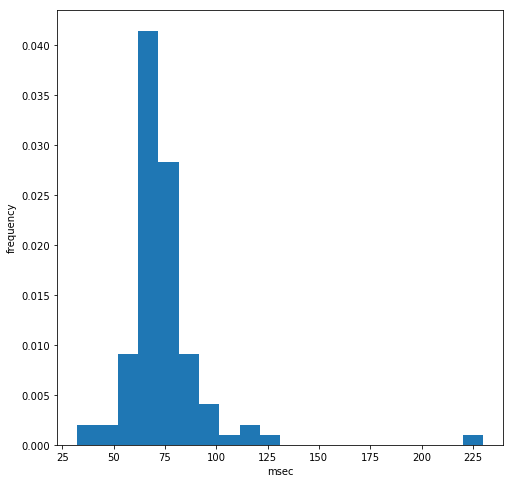

In [20]:
run_analysis( lazyqt.LazyQtAccessor( local_path ), ["lazyqt","local_disk"])

### Local HTTP server serving local data

['lazyqt', 'local_nginx', '1_threads']: 69.091623 ms per frame
['lazyqt', 'local_nginx', '2_threads']: 207.707100 ms per frame
['lazyqt', 'local_nginx', '4_threads']: 202.431576 ms per frame
['lazyqt', 'local_nginx', '8_threads']: 207.786407 ms per frame


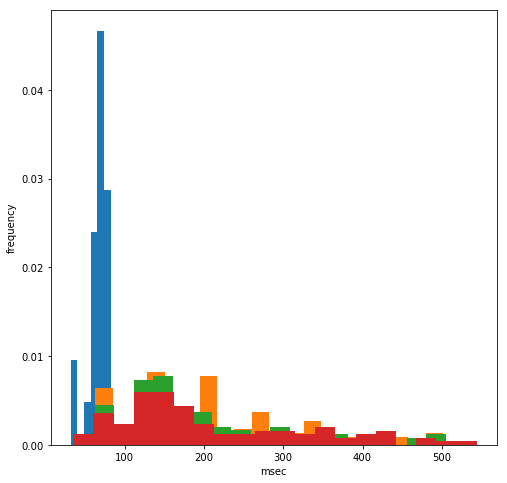

In [8]:
run_analysis( lazyqt.LazyQtAccessor( local_nginx_url ), ["lazyqt","local_nginx"] )

### Contacting CI directly 

In [9]:
run_analysis( lazyqt.LazyQtAccessor( ci_url_root ), ["lazyqt","ci"] )

KeyboardInterrupt: 

# Local lazycache server, non-caching


### Using local disk

In [ ]:
def lazycache_berna( host ):
    return lazycache.LazycacheAccessor("%s/v1/berna/srv/data/" % host)

def lazycache_nginx( host ):
    return lazycache.LazycacheAccessor("%s/v1/nginx_data/" % host)

def lazycache_ci( host ):
        return lazycache.LazycacheAccessor("%s/v1/org/oceanobservatories/rawdata/files/" % host)
    
keys = ["lazycache","local","uncached"]

In [ ]:

## run this one twice to demonstrate caching isn't enabled

seed = random.randint(0,65535)
repo = lazycache_berna( local_uncached_url )

run_analysis( repo, keys + ["local_disk"], seed = seed  )
run_analysis( repo, keys + ["local_disk"], seed = seed  )

### connecting to local HTTP server

In [ ]:
run_analysis( lazycache_nginx( local_uncached_url ), keys + ["local_nginx"]  )

### contacting CI directly

In [ ]:
run_analysis( lazycache_ci( local_uncached_url ), keys + ["ci"]  )

# Local Lazycache server, with caching enabled


In [ ]:
keys = ["lazycache","local","cached"]

seed = random.randint(0,65535)
run_analysis( lazycache_berna( local_cached_url ), keys + ["local_disk"], seed = seed )
run_analysis( lazycache_berna( local_cached_url ), keys + ["local_disk"], seed = seed )

seed = random.randint(0,65535)
run_analysis( lazycache_nginx( local_cached_url ), keys + ["local_nginx"], seed = seed  )
run_analysis( lazycache_nginx( local_cached_url ), keys + ["local_nginx"], seed = seed  )

seed = random.randint(0,65535)
run_analysis( lazycache_ci( local_cached_url ), keys + ["ci"], seed = seed  )
run_analysis( lazycache_ci( local_cached_url ), keys + ["ci"], seed = seed  )

# Google App Engine instance of Lazycache

## Without cache

In [ ]:
keys = ["lazycache", "gae", "uncached"]

seed = random.randint(0,65535)
run_analysis( lazycache_ci( gae_uncached_url ), keys + ["ci"], seed = seed )
run_analysis( lazycache_ci( gae_uncached_url ), keys + ["ci"], seed = seed  )

### With cache

In [ ]:
keys = ["lazycache", "gae", "cached"]

seed = random.randint(0,65535)
run_analysis( lazycache_ci( gae_cached_url ), keys + ["ci"], seed = seed  )
run_analysis( lazycache_ci( gae_cached_url ), keys + ["ci"], seed = seed  )